# Commodity price forecasting using FFNN

In [1]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing methods
from sklearn.preprocessing import StandardScaler

# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# deep learning libraries
from keras.models import Input, Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU
from keras.layers import Conv1D, MaxPooling1D
from keras import layers
from keras import losses
from keras import optimizers
from keras import metrics
from keras import callbacks
from keras import initializers

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import and basic analysis

In [3]:
DATADIR = 'data/'
MODELDIR = '../checkpoints/commodity/nn/'

path = os.path.join(DATADIR, 'gold-silver.csv')
data = pd.read_csv(path, header=0, index_col=[0], infer_datetime_format=True, sep=';')

data.head()

,gold,silver
Date,,
1993/11/01,369.25,4.25
1993/12/01,376.30,4.62
1994/01/01,394.00,5.24
1994/02/01,384.50,5.31
1994/03/01,378.75,5.32


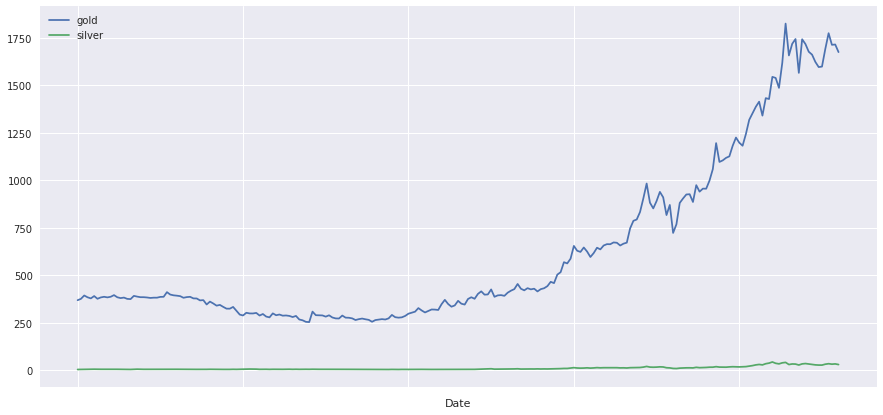

In [4]:
data[['gold', 'silver']].plot();

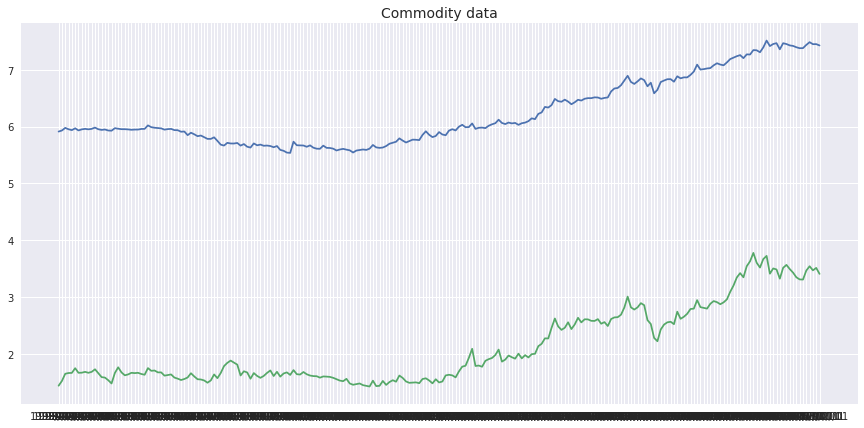

In [5]:
plt.plot(np.log(data.gold), label='log(gold)')
plt.plot(np.log(data.silver), label='log(silver)')
plt.title('Commodity data', fontsize='14')
plt.show()

## 2. Data preparation

In [6]:
# function to prepare x and y variable
# for the univariate series
def prepare_data(df, steps=1):
    temp = df.shift(-steps).copy()
    y = temp[:-steps].copy()
    X = df[:-steps].copy()
    return X, y

In [7]:
gold_X, gold_y = prepare_data(np.log(data[['gold']]), steps=1)
silver_X, silver_y = prepare_data(np.log(data[['silver']]), steps=1)

len(gold_X), len(gold_y), len(silver_X), len(silver_y)

(230, 230, 230, 230)

In [8]:
X = pd.concat([gold_X, silver_X], axis=1)
y = pd.concat([gold_y, silver_y], axis=1)

In [9]:
X.head()

,gold,silver
Date,,
1993/11/01,5.911474,1.446919
1993/12/01,5.930387,1.530395
1994/01/01,5.976351,1.656321
1994/02/01,5.951944,1.669592
1994/03/01,5.936876,1.671473


In [10]:
y.head()

,gold,silver
Date,,
1993/11/01,5.930387,1.530395
1993/12/01,5.976351,1.656321
1994/01/01,5.951944,1.669592
1994/02/01,5.936876,1.671473
1994/03/01,5.968708,1.754404


In [11]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, 
                                                    random_state=seed, shuffle=False)

print('Training and test data shape:')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

Training and test data shape:


((218, 2), (218, 2), (12, 2), (12, 2))

## 3. Model building

In [12]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred):
    
    y_train_inv, y_test_inv = np.exp(y_train), np.exp(y_test)
    y_train_pred_inv, y_test_pred_inv = np.exp(y_train_pred), np.exp(y_test_pred)
    
    # MAE and NRMSE calculation for gold
    y_train_gold = y_train_inv.values[:, 0]
    y_train_pred_gold = y_train_pred_inv[:, 0]  
    y_test_gold = y_test_inv.values[:, 0]
    y_test_pred_gold = y_test_pred_inv[:, 0]
    
    train_rmse_g = np.sqrt(mean_squared_error(y_train_gold, y_train_pred_gold))
    train_mae_g = np.round(mean_absolute_error(y_train_gold, y_train_pred_gold), 3)
    train_nrmse_g = np.round(train_rmse_g/np.std(y_train_gold), 3)

    test_rmse_g = np.sqrt(mean_squared_error(y_test_gold, y_test_pred_gold))
    test_mae_g = np.round(mean_absolute_error(y_test_gold, y_test_pred_gold), 3)
    test_nrmse_g = np.round(test_rmse_g/np.std(y_test_gold), 3)
    
    print('Training and test result for gold:')
    print(f'Training MAE: {train_mae_g}')
    print(f'Trainig NRMSE: {train_nrmse_g}')
    print(f'Test MAE: {test_mae_g}')
    print(f'Test NRMSE: {test_nrmse_g}')
    print()
    
    
    # MAE and NRMSE calculation for silver
    y_train_silver = y_train_inv.values[:, 1]
    y_train_pred_silver = y_train_pred_inv[:, 1]
    y_test_silver = y_test_inv.values[:, 1]
    y_test_pred_silver = y_test_pred_inv[:, 1] 
    
    train_rmse_s = np.sqrt(mean_squared_error(y_train_silver, y_train_pred_silver))
    train_mae_s = np.round(mean_absolute_error(y_train_silver, y_train_pred_silver), 3)
    train_nrmse_s = np.round(train_rmse_s/np.std(y_train_silver), 3)

    test_rmse_s = np.sqrt(mean_squared_error(y_test_silver, y_test_pred_silver))
    test_mae_s = np.round(mean_absolute_error(y_test_silver, y_test_pred_silver), 3)
    test_nrmse_s = np.round(test_rmse_s/np.std(y_test_silver), 3)

    print('Training and test result for silver:')
    print(f'Training MAE: {train_mae_s}')
    print(f'Trainig NRMSE: {train_nrmse_s}')
    print(f'Test MAE: {test_mae_s}')
    print(f'Test NRMSE: {test_nrmse_s}')
    
    return y_train_pred_inv, y_test_pred_inv

In [13]:
def model_training(X_train, X_test, y_train, model, batch=4, name='m'):
    start = time.time()
    loss = losses.mean_squared_error
    opt = optimizers.Adam()
    metric = [metrics.mean_absolute_error]
    model.compile(loss=loss, optimizer=opt, metrics=metric)

    callbacks_list = [callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.001)]

    history = model.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=batch, 
                        verbose=0,
                        shuffle=False,
                        callbacks=callbacks_list
                       )

    # save model weights and 
    if os.path.exists(MODELDIR):
        pass
    else:
        os.makedirs(MODELDIR)
    m_name = name + str('.h5')
    w_name = name + str('_w.h5')
    model.save(os.path.join(MODELDIR, m_name))
    model.save_weights(os.path.join(MODELDIR, w_name))

    # prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    end = time.time()
    time_taken = np.round((end-start), 3)
    print(f'Time taken to complete the process: {time_taken} seconds')
    
    return y_train_pred, y_test_pred, history

In [14]:
features = X_train.shape[1]
xavier = initializers.glorot_normal()

### FFNN - v1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 12        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 19.492 seconds
Training and test result for gold:
Training MAE: 145.376
Trainig NRMSE: 0.424
Test MAE: 120.271
Test NRMSE: 2.443

Training and test result for silver:
Training MAE: 2.167
Trainig NRMSE: 0.329
Test MAE: 4.261
Test NRMSE: 1.867


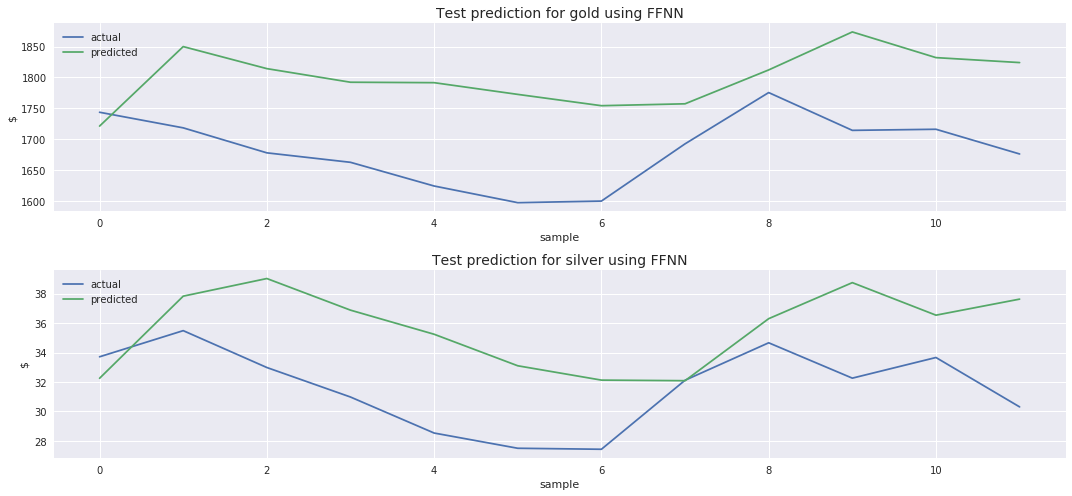

In [15]:
model = Sequential()

model.add(Dense(3, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(5, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))

model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=1, name='fc-v1')

y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using FFNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using FFNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## FFNN - v2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 8         
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 6.219 seconds
Training and test result for gold:
Training MAE: 108.791
Trainig NRMSE: 0.627
Test MAE: 567.824


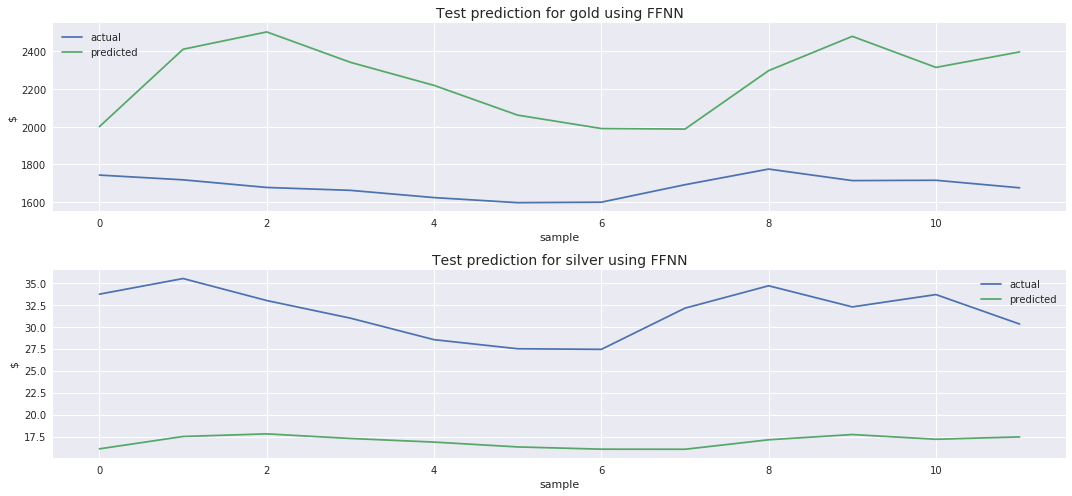

In [16]:
model = Sequential()
model.add(Dense(3, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(5, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(5, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(3, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(2, kernel_initializer=xavier))
model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=4, name='fc-v2')

y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using FFNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using FFNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## FFNN - v3

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 12        
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 20.848 seconds
Training and test result for gold:
Training MAE: 266.405
Trainig NRMSE: 1.016
Test MAE: 1187.96
Test NRMSE: 22.362

Training and test result for silver:
Training MAE: 5.278
Trainig NRMSE: 1.021
Test MAE: 23.546
Test NRMSE: 9.088


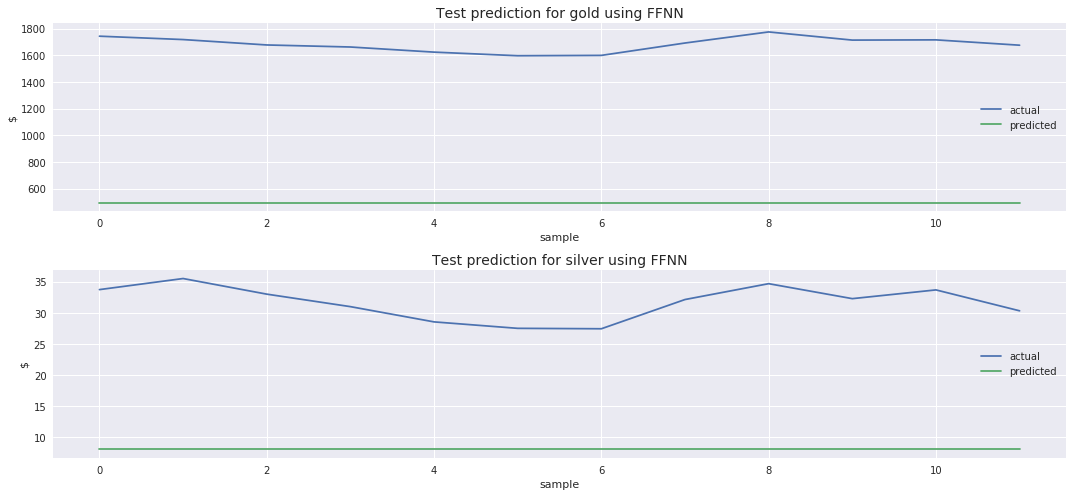

In [17]:
model = Sequential()
model.add(Dense(5, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(5, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=1, name='fc-v3')

y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using FFNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using FFNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## FFNN - v4

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 7)                 21        
_________________________________________________________________
dense_13 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 16        
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 20.388 seconds
Training and test result for gold:
Training MAE: 266.405
Trainig NRMSE: 1.016
Test MAE: 1187.96
Test NRMSE: 22.362

Training and test result for silver:
Training MAE: 5.278
Trainig NRMSE: 1.021
Test MAE: 23.546
Test NRMSE: 9.088


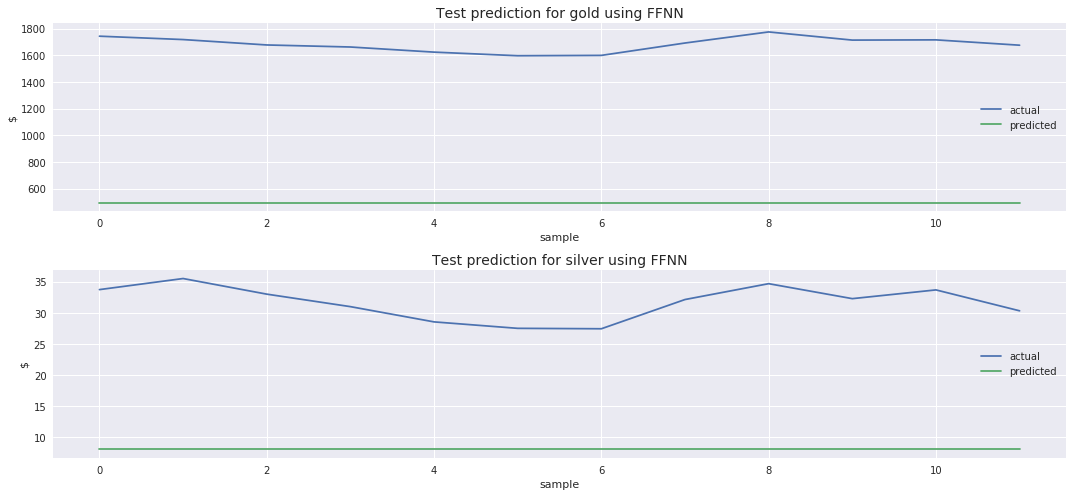

In [18]:
model = Sequential()
model.add(Dense(7, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(7, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=1, name='fc-v4')

y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using FFNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using FFNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## FFNN - v5 (Final model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_16 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 22        
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 21.42 seconds
Training and test result for gold:
Training MAE: 158.563
Trainig NRMSE: 0.447
Test MAE: 54.364
Test NRMSE: 1.194

Training and test result for silver:
Training MAE: 3.343
Trainig NRMSE: 0.459
Test MAE: 4.665
Test NRMSE: 2.025


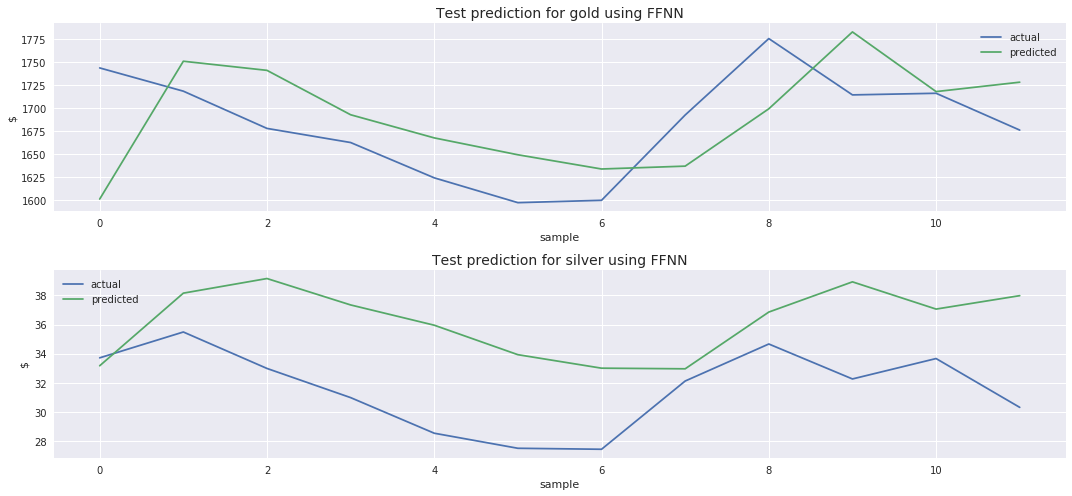

In [19]:
model = Sequential()
model.add(Dense(10, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))
model.add(Dense(10, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=1, name='fc-v5')

y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using FFNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using FFNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## FFNN - v6

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 22        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________
Time taken to complete the process: 19.549 seconds
Training and test result for gold:
Training MAE: 105.639
Trainig NRMSE: 0.302
Test MAE: 64.545
Test NRMSE: 1.292

Training and test result for silver:
Training MAE: 2.042
Trainig NRMSE: 0.309
Test MAE: 3.402
Test NRMSE: 1.49


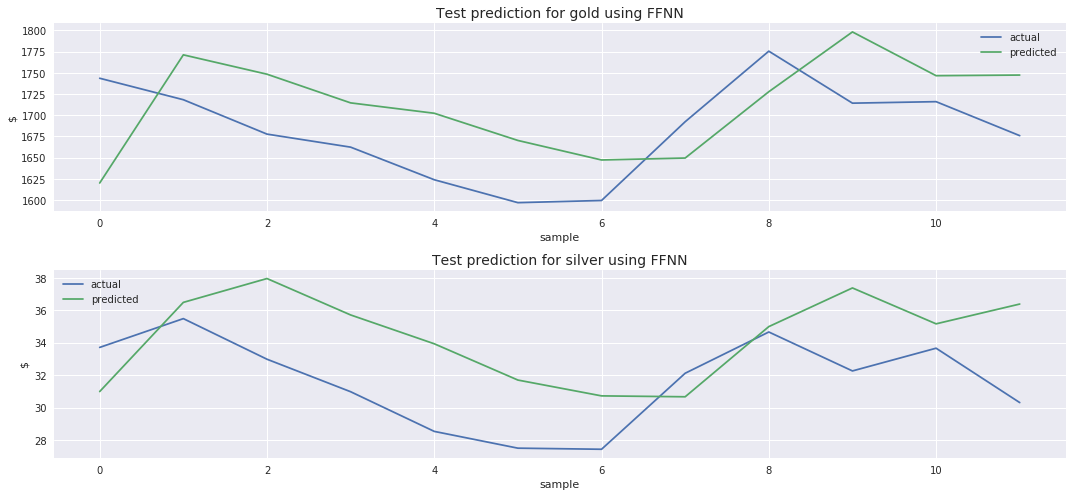

In [20]:
model = Sequential()
model.add(Dense(10, input_dim = features, kernel_initializer=xavier, 
                activation='relu'))

model.add(Dense(2, kernel_initializer=xavier))
model.summary()

y_train_pred, y_test_pred, history = model_training(X_train, X_test, y_train, model, batch=1, name='fc-v6')

y_train_pred, y_test_pred = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

plt.subplot(211)
plt.plot(np.exp(y_test.values[:, 0]), label='actual')
plt.plot(y_test_pred[:, 0], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for gold using FFNN', fontsize=14)
plt.legend()

plt.subplot(212)
plt.plot(np.exp(y_test.values[:, 1]), label='actual')
plt.plot(y_test_pred[:, 1], label='predicted')
plt.ylabel('$')
plt.xlabel('sample')
plt.title('Test prediction for silver using FFNN', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()